In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [ ]:
# Define paths to your datasets
tumor_data_path = "/content/drive/MyDrive/Brain_classification/tumor_or_notumor/"
tumor_type_data_path = "/content/drive/MyDrive/Brain_classification/type_of_tumor/"


In [ ]:
# Load Stage 1 dataset: Tumor vs No Tumor
train_dir1= tumor_data_path + 'Training'
test_dir1= tumor_data_path + 'Testing'

In [ ]:
# Load Stage 2 dataset: Tumor Types
train_dir2= tumor_type_data_path + 'Training'
test_dir2= tumor_type_data_path + 'Testing'

The tumor and notumor images are different in number, we have to generage more non-tumor images

Tumor images: 4,135

No tumor images: 1,592

Imbalance ratio: ~2.6:1

we want to reduce that imbalance and have 3,500 no tumor images

In [ ]:
source_dir = '/content/drive/MyDrive/Brain_classification/tumor_or_notumor/Training/notumor'
save_dir = source_dir

os.makedirs(save_dir, exist_ok=True)

# Count how many images to generate
target_total = 3500
existing_count = len(os.listdir(source_dir))
to_generate = target_total - existing_count

In [ ]:
#Create Image generator for the training dataset to have variations in images
train_datagen = ImageDataGenerator(

    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',

)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image

In [ ]:
# # Load original images
# image_files = os.listdir(source_dir)
# count = 0

# for image_file in image_files:
#     if count >= to_generate:
#         break
#     img_path = os.path.join(source_dir, image_file)
#     img = load_img(img_path, color_mode='grayscale')  # change to 'rgb' if needed
#     x = img_to_array(img)
#     x = x.reshape((1,) + x.shape)

#     # Save augmented versions
#     for batch in train_datagen.flow(x, batch_size=1, save_to_dir=save_dir,
#                               save_prefix='aug', save_format='jpg'):
#         count += 1
#         if count >= to_generate:
#             break

# print(f"Augmented and saved {count} images to '{save_dir}'")

In [ ]:
number_of_notumor_images= len(os.listdir(source_dir))
number_of_tumor_images=len(os.listdir(train_dir1 +'/Tumor'))
print(f"number_of_notumor_images: {number_of_notumor_images}")
print(f'number_of_tumor_images: {number_of_tumor_images}')

number_of_notumor_images: 3307
number_of_tumor_images: 4135


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir1,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=['Tumor', 'notumor']
)

val_generator = train_datagen.flow_from_directory(
    train_dir1,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=['Tumor', 'notumor']
)


Found 5954 images belonging to 2 classes.
Found 1488 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)


{'Tumor': 0, 'notumor': 1}


I want to output tumor or notumor when i access the keys as 0 or 1 but in this arrangement, I won't be able to do that. Hence we reverse the arrangement for our class name


In [ ]:
class_indices = train_generator.class_indices
class_name = {v: k for k, v in class_indices.items()}  # reverse the dict
print(class_name)


{0: 'Tumor', 1: 'notumor'}


(32, 2)
(32, 224, 224, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


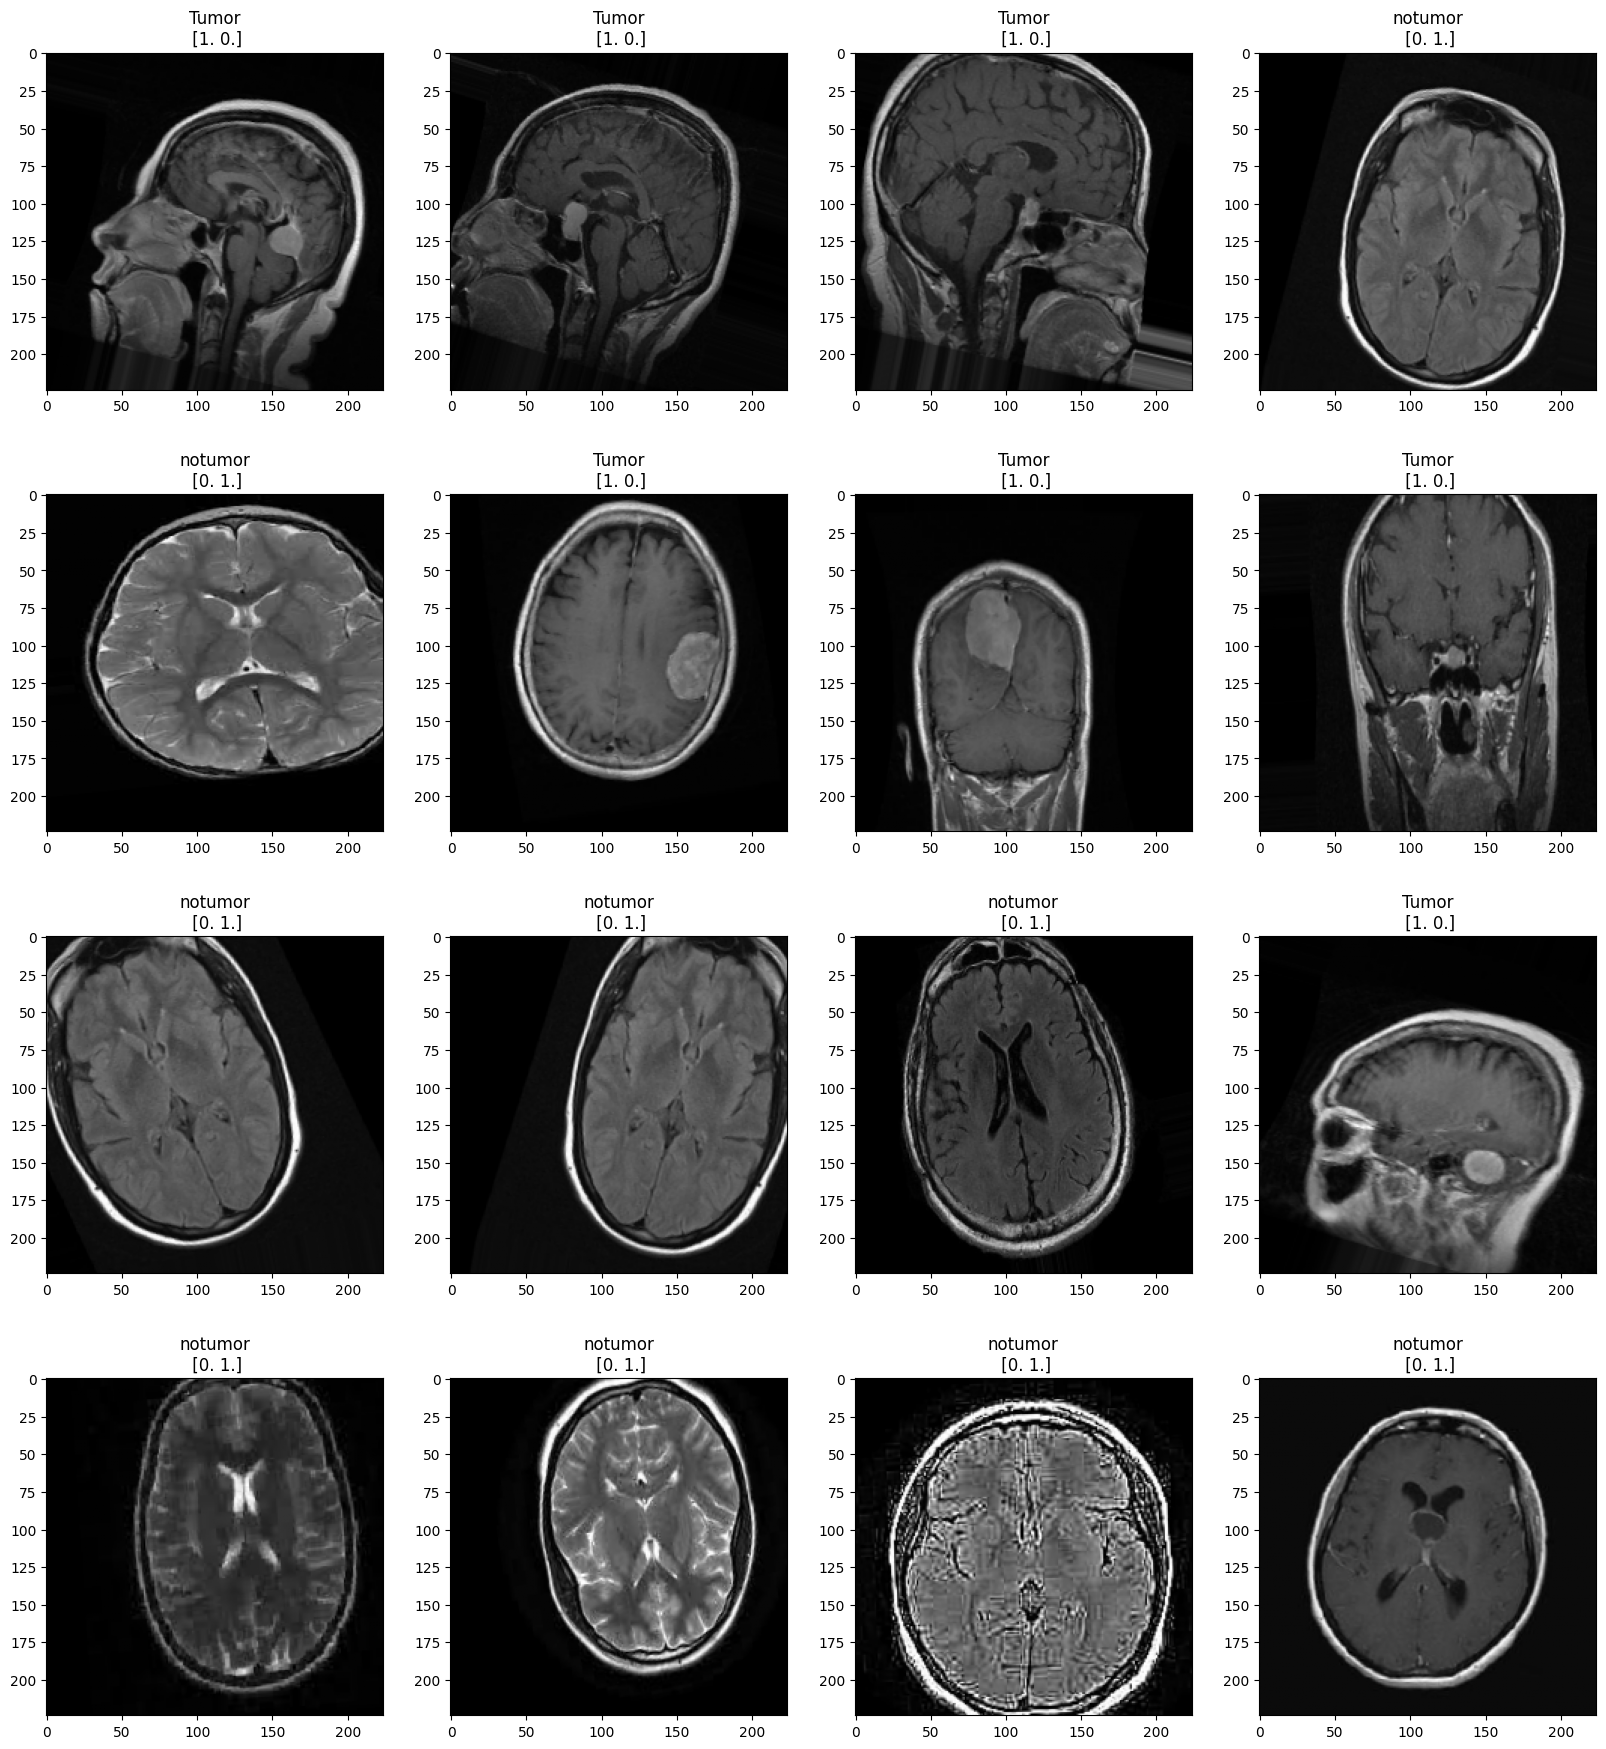

In [ ]:
class_name= {0: 'Tumor', 1: 'notumor'}
trainiter=iter(train_generator)
images,labels= next(trainiter)
print(labels.shape)
print(images.shape)
print(type(labels))
print(type(images))

fig,axes= plt.subplots(4,4, figsize=(20,22))
axes= axes.ravel()

for i in range(16):
  axes[i].imshow(images[i], cmap='gray')
  index=np.argmax(labels[i])
  axes[i].set_title(f'{class_name[index]}\n {labels[i]}')
plt.show()


In [ ]:
#1 2 3    0.9 0.7 1.5
#4 5 6 -> 2.2 3   3.8
#7 8 9    4.5 5.3 5.9

input_size=(224,224,1)

model=Sequential()

model.add(Conv2D(16,(3,3), activation='relu', input_shape=input_size))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

opt= Adam(learning_rate=0.0008)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 13,934,786 (53.16 MB)

 Trainable params: 13,930,978 (53.14 MB)

 Non-trainable params: 3,808 (14.88 KB)

In [ ]:
modelcheckpoint=ModelCheckpoint(
    'model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode=max,
    verbose=1
)

#Learning Rate Scheduler (Cosine Anaeling)
def scheduler(epoch, lr):
  return 0.001 *(0.5 **(epoch//10))
lr_scheduler= LearningRateScheduler(scheduler)

<ipython-input-17-68cc80b314d1>:1: UserWarning: ModelCheckpoint mode '<built-in function max>' is unknown, fallback to auto mode.
  modelcheckpoint=ModelCheckpoint(


In [ ]:
#Train the model
epochs=30
history= model.fit(train_generator,
                   callbacks=[modelcheckpoint,lr_scheduler],
                   validation_data=val_generator,
                   epochs=epochs)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9297 - loss: 0.2024
Epoch 1: val_accuracy improved from -inf to 0.55645, saving model to model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 1656s 9s/step - accuracy: 0.9299 - loss: 0.2020 - val_accuracy: 0.5565 - val_loss: 2.2351 - learning_rate: 0.0010
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9721 - loss: 0.0971
Epoch 2: val_accuracy improved from 0.55645 to 0.59677, saving model to model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 325ms/step - accuracy: 0.9721 - loss: 0.0970 - val_accuracy: 0.5968 - val_loss: 0.9065 - learning_rate: 0.0010
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9586 - loss: 0.1176
Epoch 3: val_accuracy improved from 0.59677 to 0.84879, saving model to model.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 324ms/step - accuracy: 0.9586 - loss: 0.1175 - val_accuracy: 0.8488 - val_loss: 0.4182 - learning_rate: 0.0010
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - acc

AttributeError: module 'numpy' has no attribute 'arrange'

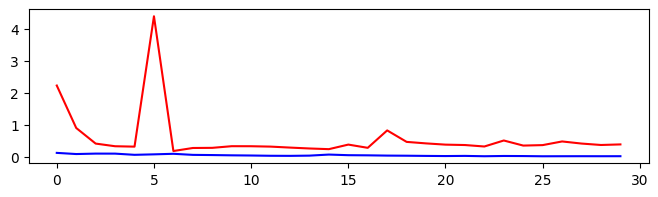

In [ ]:
plt.figure(figsize=(8,2))
plt.plot (history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.xticks(np.arrange(5, epochs+1, 5))
plt.yticks(np.arrange(0,1.5,0.1))
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
from PIL import Image, ImageOps
import os
import random

model = keras.models.load_model("model.keras")

fig, axes = plt.subplots(4,4, figsize=(20,22))
axes = axes.ravel()

class_name= {0: 'Tumor', 1: 'notumor'}

test_dir_folders = os.listdir(test_dir1)


for i in range(16):
  test_dir_folder = random.choice(test_dir_folders)
  test_dir_files = os.listdir(os.path.join(test_dir1,test_dir_folder))
  img_path = os.path.join(test_dir1,test_dir_folder,random.choice(test_dir_files))

  img = Image.open(img_path)
  img = ImageOps.grayscale(img)
  img_pred = np.array(img)
  img_pred = np.expand_dims(img_pred, axis=0)
  img_pred = img_pred / 255.0

  pred = model.predict(img_pred)[0]

  pred_index = np.argmax(pred, axis=-1)
  score = np.round(pred[pred_index], 4) * 100
  actual_index = np.argmax(labels[i], axis=-1)
  print(pred)

  axes[i].imshow(img,cmap='gray')
  axes[i].set_title(f'Predicted: {class_name[pred_index]} \n Label: {test_dir_folder} \n Score: {score}')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Class mapping
class_to_index = {'Tumor': 0, 'notumor': 1}
y_true = []
y_pred = []

# Loop through all test images
for label_folder in os.listdir(test_dir1):
    label_path = os.path.join(test_dir1, label_folder)
    if not os.path.isdir(label_path):
        continue

    for file in os.listdir(label_path):
        file_path = os.path.join(label_path, file)
        try:
            img = Image.open(file_path).convert('L')
            img = img.resize((150, 150))
            img_array = np.expand_dims(np.array(img), axis=(0, -1)) / 255.0

            pred = model.predict(img_array, verbose=0)[0]
            pred_label = np.argmax(pred)
            true_label = class_to_index[label_folder]

            y_pred.append(pred_label)
            y_true.append(true_label)
        except Exception as e:
            print(f"Skipped {file_path} due to error: {e}")

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_index.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Stage 2: Tumor Type

In [ ]:
# Load Stage 2 dataset: Tumor Types
train_dir2= tumor_type_data_path + 'Training'
test_dir2= tumor_type_data_path + 'Testing'

Data Generation

* Improves model generalization
  
* Simulates real-world variability

* Reduces overfitting




In [ ]:
# ImageDataGenerator for Stage Two
tumor_type_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_gen2 = tumor_type_datagen.flow_from_directory(
    train_dir2,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=['glioma', 'meningioma', 'pituitary']
)

val_gen2 = tumor_type_datagen.flow_from_directory(
    train_dir2,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=['glioma', 'meningioma', 'pituitary']
)

class_indices2 = train_gen2.class_indices
class_name2 = {v: k for k, v in class_indices2.items()}
print(class_name2)


Model Architecture

In [ ]:
model2 = Sequential()

model2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(512, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(3, activation='softmax'))  # <-- Three output classes

opt2 = Adam(learning_rate=0.0008)
model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])
model2.summary()


Training

In [ ]:
checkpoint2 = ModelCheckpoint(
    'tumor_type_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

def scheduler2(epoch, lr):
    return 0.001 * (0.5 ** (epoch // 10))

lr_scheduler2 = LearningRateScheduler(scheduler2)

epochs2 = 30

history2 = model2.fit(
    train_gen2,
    validation_data=val_gen2,
    epochs=epochs2,
    callbacks=[checkpoint2, lr_scheduler2]
)


Plot Results

In [ ]:
plt.figure(figsize=(8, 2))
plt.plot(history2.history['loss'], label='Training Loss', color='b')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='r')
plt.xticks(np.arange(5, epochs2+1, 5))
plt.yticks(np.arange(0, 1.5, 0.1))
plt.title('Training vs Validation Loss - Tumor Type')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Stage 2 Inference

In [ ]:
from PIL import Image, ImageOps
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

# Load Stage 2 model
model_stage2 = keras.models.load_model('tumor_type_model.keras')

# Class labels
class_names_stage2 = {0: 'glioma', 1: 'meningioma', 2: 'pituitary'}
#test_dir2 = "/content/drive/MyDrive/Brain_classification/Yes_classification/Stage2_Test"
test_dir_folders2 = os.listdir(test_dir2)

# Visualization
fig, axes = plt.subplots(4, 4, figsize=(20, 22))
axes = axes.ravel()

for i in range(16):
    folder = random.choice(test_dir_folders2)
    img_file = random.choice(os.listdir(os.path.join(test_dir2, folder)))
    img_path = os.path.join(test_dir2, folder, img_file)

    img = Image.open(img_path).convert('L')  # grayscale
    img = img.resize((150, 150))
    img_pred = np.expand_dims(np.array(img), axis=(0, -1)) / 255.0

    pred = model_stage2.predict(img_pred, verbose=0)[0]
    pred_index = np.argmax(pred)
    score = np.round(pred[pred_index], 4) * 100

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Predicted: {class_names_stage2[pred_index]}\nLabel: {folder}\nScore: {score:.2f}%')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Class mapping
class_to_index_stage2 = {'glioma': 0, 'meningioma': 1, 'pituitary': 2}
y_true_stage2 = []
y_pred_stage2 = []

# Loop through test images
for label_folder in os.listdir(test_dir2):
    label_path = os.path.join(test_dir2, label_folder)
    if not os.path.isdir(label_path):
        continue

    for file in os.listdir(label_path):
        file_path = os.path.join(label_path, file)
        try:
            img = Image.open(file_path).convert('L')
            img = img.resize((150, 150))
            img_array = np.expand_dims(np.array(img), axis=(0, -1)) / 255.0

            pred = model_stage2.predict(img_array, verbose=0)[0]
            pred_label = np.argmax(pred)
            true_label = class_to_index_stage2[label_folder]

            y_pred_stage2.append(pred_label)
            y_true_stage2.append(true_label)
        except Exception as e:
            print(f"Skipped {file_path} due to error: {e}")

# Accuracy
acc_stage2 = accuracy_score(y_true_stage2, y_pred_stage2)
print(f"\n✅ Stage 2 Test Accuracy: {acc_stage2:.4f}")

# Confusion Matrix
cm_stage2 = confusion_matrix(y_true_stage2, y_pred_stage2)
disp_stage2 = ConfusionMatrixDisplay(confusion_matrix=cm_stage2,
                                     display_labels=list(class_to_index_stage2.keys()))
disp_stage2.plot(cmap=plt.cm.Blues)
plt.title("Stage 2 Confusion Matrix")
plt.show()
